In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [4]:
raw_dataset = pd.read_csv("all_matches_numeric.csv")

dataset = raw_dataset.copy()
dataset.head(10)



,innings,runs,venue_mean,count_batsmen,count_bowlers,batsmen_mean,bowlers_mean
0,1,61,46.294118,3,3,0.862709,1.852505
1,2,26,46.294118,6,3,0.885467,1.378734
2,1,54,45.042553,3,3,0.901586,1.292998
3,2,51,46.137255,4,3,0.994656,1.331309
4,1,56,45.291339,2,4,1.235198,1.498722
5,2,47,45.291339,3,4,1.144128,1.155171
6,1,16,38.333333,2,2,1.213088,1.276964
7,2,28,38.333333,4,3,1.046308,1.277059
8,1,72,48.428571,6,5,1.136483,1.285318
9,2,61,48.428571,4,4,1.126740,1.434141


In [5]:
number_sample = len(dataset)
train_dataset = dataset[:int(0.95*number_sample)]
test_dataset = dataset[int(0.95*number_sample):]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('runs')
test_labels = test_features.pop('runs')

In [7]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

help(normalizer)

Help on Normalization in module tensorflow.python.keras.layers.preprocessing.normalization object:

class Normalization(tensorflow.python.keras.engine.base_preprocessing_layer.CombinerPreprocessingLayer)
 |  Normalization(*args, **kwargs)
 |  
 |  Feature-wise normalization of the data.
 |  
 |  This layer will coerce its inputs into a distribution centered around
 |  0 with standard deviation 1. It accomplishes this by precomputing the mean and
 |  variance of the data, and calling (input-mean)/sqrt(var) at runtime.
 |  
 |  What happens in `adapt`: Compute mean and variance of the data and store them
 |    as the layer's weights. `adapt` should be called before `fit`, `evaluate`,
 |    or `predict`.
 |  
 |  Attributes:
 |      axis: Integer or tuple of integers, the axis or axes that should be
 |        "kept". These axes are not be summed over when calculating the
 |        normalization statistics. By default the last axis, the `features` axis
 |        is kept and any `space` or 

In [8]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.002))
  return model

In [9]:
dnn_model = build_and_compile_model(normalizer)

In [10]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    verbose=2, epochs=40)

Epoch 1/40
49/49 - 1s - loss: 39.7114
Epoch 2/40
49/49 - 0s - loss: 14.6445
Epoch 3/40
49/49 - 0s - loss: 9.7499
Epoch 4/40
49/49 - 0s - loss: 8.9151
Epoch 5/40
49/49 - 0s - loss: 8.3967
Epoch 6/40
49/49 - 0s - loss: 8.1080
Epoch 7/40
49/49 - 0s - loss: 7.8808
Epoch 8/40
49/49 - 0s - loss: 7.8099
Epoch 9/40
49/49 - 0s - loss: 7.7652
Epoch 10/40
49/49 - 0s - loss: 7.6452
Epoch 11/40
49/49 - 0s - loss: 7.6172
Epoch 12/40
49/49 - 0s - loss: 7.5936
Epoch 13/40
49/49 - 0s - loss: 7.5401
Epoch 14/40
49/49 - 0s - loss: 7.5847
Epoch 15/40
49/49 - 0s - loss: 7.5371
Epoch 16/40
49/49 - 0s - loss: 7.5129
Epoch 17/40
49/49 - 0s - loss: 7.5381
Epoch 18/40
49/49 - 0s - loss: 7.4889
Epoch 19/40
49/49 - 0s - loss: 7.4639
Epoch 20/40
49/49 - 0s - loss: 7.4962
Epoch 21/40
49/49 - 0s - loss: 7.5293
Epoch 22/40
49/49 - 0s - loss: 7.4987
Epoch 23/40
49/49 - 0s - loss: 7.5011
Epoch 24/40
49/49 - 0s - loss: 7.4462
Epoch 25/40
49/49 - 0s - loss: 7.4509
Epoch 26/40
49/49 - 0s - loss: 7.4367
Epoch 27/40
49/49 -

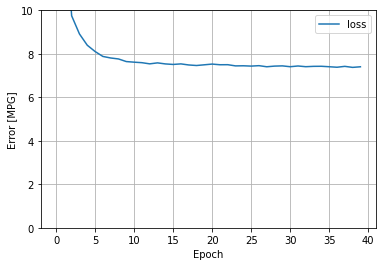

In [11]:
plot_loss(history)

In [12]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    test_features,
    test_labels, verbose=2)

3/3 - 0s - loss: 7.6440


In [13]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=2)

3/3 - 0s - loss: 7.6440


In [14]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [15]:
venue_lookup = pd.read_csv("venue.csv")
batsmen_lookup = pd.read_csv("batsmen.csv")
bowlers_lookup = pd.read_csv("bowlers.csv")

venue_lookup = venue_lookup.set_index("venue")["venue_mean_runs"].to_dict()
batsmen_lookup = batsmen_lookup.set_index("batsmen")["batsmen_mean_runs"].to_dict()
bowlers_lookup = bowlers_lookup.set_index("bowlers")["bowlers_mean_runs"].to_dict()

In [16]:
def predictor(testInput):
    prediction = 46.5
    
    batsman_mean = sum(batsmen_lookup.values())/len(batsmen_lookup)
    bowler_mean = sum(bowlers_lookup.values())/len(bowlers_lookup)
    
    df = pd.read_csv(testInput)
    
    df["venue_mean"] = 0
    df["count_batsmen"] = 0
    df["count_bowlers"] = 0
    df["batsmen_mean"] = 0
    df["bowlers_mean"] = 0
    
    batsmen = df["batsmen"][0].strip().split(',')
    bowlers = df["bowlers"][0].strip().split(',')
    venue = df["venue"][0]
    
    df["venue_mean"] = venue_lookup[venue]
    df["count_batsmen"] = len(batsmen)
    df["count_bowlers"] = len(bowlers)
    df["batsmen_mean"] = sum([batsmen_lookup.get(name, batsman_mean) for name in batsmen])/len(batsmen)
    df["bowlers_mean"] = sum([bowlers_lookup.get(name, bowler_mean) for name in bowlers])/len(bowlers)
    
    df = df.drop(columns = ["venue", "batsmen", "bowlers", "batting_team", "bowling_team"])
    
    prediction = dnn_model.predict(df)
    
    return prediction[0, 0]

In [17]:
predictor("submissionFormat/22_inn1.csv")

40.26749